In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label

## Helper functions

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if vis == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature, hog_vis = get_hog_features(feature_image[:,:,channel], 
                                                    orient, pix_per_cell, cell_per_block, 
                                                    vis=True, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features, hog_vis = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                   pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                         hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                    orient, pix_per_cell, cell_per_block, 
                                                    vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                   pix_per_cell, cell_per_block, vis=False, feature_vec=True)                    
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    if vis == True:
        return features, hog_vis
    else:
        return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def normalise(image):
    return (image - image.mean()) / (image.max() - image.min())

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=5, 
                    pix_per_cell=8, cell_per_block=5, 
                    hog_channel=0, spatial_feat=False, 
                    hist_feat=False, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #print("vector length:", len(features))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# copied from udacity course material
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(7, 7))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

def heatmap_visualization(image):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    hot_windows = []
    
    for xy_window, overlap, color, y_start_stop, x_start_stop in zip(xy_windows, overlaps, colors, y_start_stops, x_start_stops):
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                               xy_window=xy_window, xy_overlap=(overlap, overlap))

        temp_hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, hog_channel=hog_channel,
                                cell_per_block=cell_per_block, 
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)
        
        hot_windows = hot_windows + temp_hot_windows

    #Step 1: Generate hot windows image
    hot_windows_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 

    #Step 2: Generate heatmap image
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4)
    # Visualize the heatmap when displaying    
    heat_map_img = np.clip(heat, 0, 255)    

    #Step 3: Generate final label image
    labels = label(heat_map_img)
    final_window_img = draw_labeled_bboxes(draw_image, labels)
    
             
    # Visualize heatmap & labeled image
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,7))
    ax1.imshow(hot_windows_img)
    ax1.set_title('Hot windows', fontsize=24)
    ax2.imshow(heat_map_img)
    ax2.set_title('Heatmap', fontsize=24)
    ax3.imshow(final_window_img)
    ax3.set_title('Final label', fontsize=24)    
    f.savefig('output_images/heatmap_vis.png')
    f.show()

def show_two_figures(image1, image2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,7))
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=24)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=24)
    #f.savefig('output_images/car_notcar.png')
    f.show()

<h2>Load files</h2>

In [3]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

print("Total number of cars dataset:",len(cars))
print("Total number of not-cars dataset:",len(notcars))

Total number of cars dataset: 8792
Total number of not-cars dataset: 8968


<h1>Image Features Extraction</h1>
<h2>Visualization & Paremeters Tuning</h2>
<h3>Car & not-car image visualization</h3>

c:\users\arif makhdzir\appdata\local\programs\python\python35\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


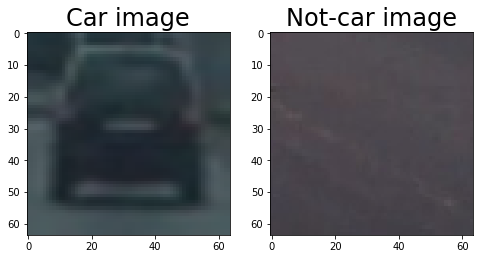

In [4]:
car_41 = plt.imread(cars[41])
notcar_41 = plt.imread(notcars[41])

show_two_figures(car_41, notcar_41, 'Car image', 'Not-car image')

<h3>HOG visualization</h3>

c:\users\arif makhdzir\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
c:\users\arif makhdzir\appdata\local\programs\python\python35\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


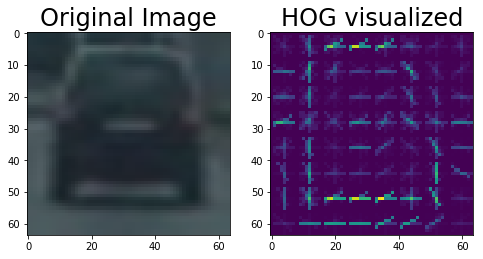

In [5]:
# Extract features
car_for_vis = cars[40:41]
car_features, hog_vis = extract_features(car_for_vis, 
                        orient=8, pix_per_cell=8, cell_per_block=2, 
                        spatial_feat=False, hist_feat=False, hog_feat=True,
                        vis=True)

# Visualize car 41 image & hog
show_two_figures(car_41, hog_vis, 'Original Image', 'HOG visualized')

<h3>HOG paremeters tuning visualization (Cars HOGs)</h2>

c:\users\arif makhdzir\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


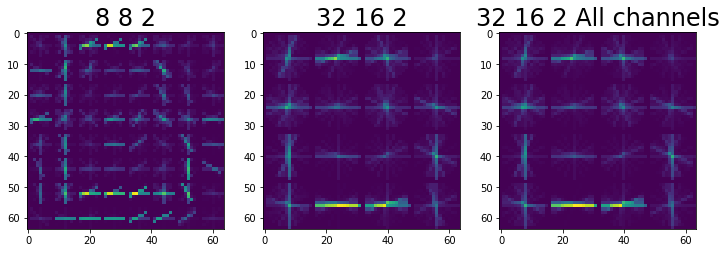

In [6]:
car_features, hog_vis1 = extract_features(car_for_vis, 
                        orient=8, pix_per_cell=8, cell_per_block=2, 
                        spatial_feat=False, hist_feat=False, hog_feat=True,
                        vis=True)

car_features, hog_vis2 = extract_features(car_for_vis, 
                        orient=32, pix_per_cell=16, cell_per_block=2, 
                        spatial_feat=False, hist_feat=False, hog_feat=True,
                        vis=True)

car_features, hog_vis3 = extract_features(car_for_vis, 
                        orient=32, pix_per_cell=16, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True,
                        vis=True)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,7))
ax1.imshow(hog_vis1)
ax1.set_title('8 8 2', fontsize=24)
ax2.imshow(hog_vis2)
ax2.set_title('32 16 2', fontsize=24)
ax3.imshow(hog_vis3)
ax3.set_title('32 16 2 All channels', fontsize=24)
#f.savefig('output_images/hog_car_vis_ext.png')

<h3>Not-cars HOGs</h3>

c:\users\arif makhdzir\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


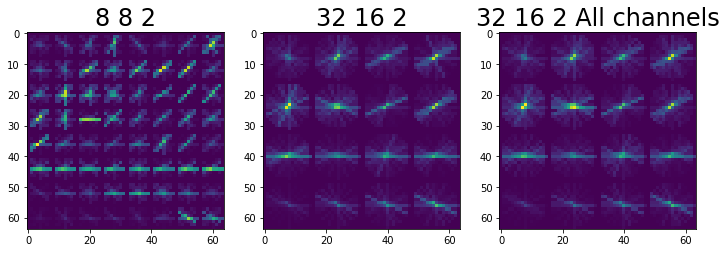

In [7]:
notcar_for_vis = notcars[40:41]

car_features, hog_vis1 = extract_features(notcar_for_vis, 
                        orient=8, pix_per_cell=8, cell_per_block=2, 
                        spatial_feat=False, hist_feat=False, hog_feat=True,
                        vis=True)

car_features, hog_vis2 = extract_features(notcar_for_vis, 
                        orient=32, pix_per_cell=16, cell_per_block=2, 
                        spatial_feat=False, hist_feat=False, hog_feat=True,
                        vis=True)

car_features, hog_vis3 = extract_features(notcar_for_vis, 
                        orient=32, pix_per_cell=16, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True,
                        vis=True)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,7))
ax1.imshow(hog_vis1)
ax1.set_title('8 8 2', fontsize=24)
ax2.imshow(hog_vis2)
ax2.set_title('32 16 2', fontsize=24)
ax3.imshow(hog_vis3)
ax3.set_title('32 16 2 All channels', fontsize=24)
#f.savefig('output_images/hog_notcar_vis_ext.png')

<h3>Color space visualization (Car image)</h3>

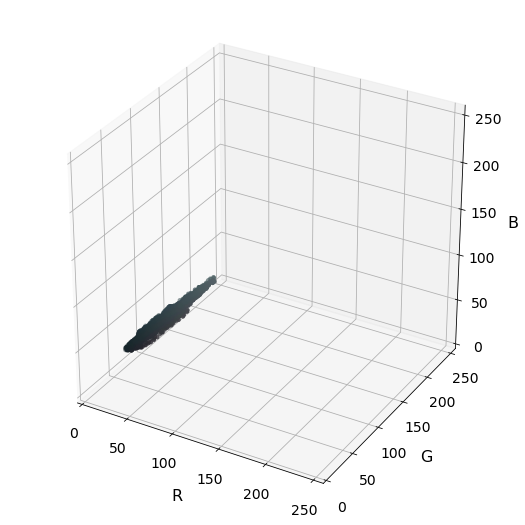

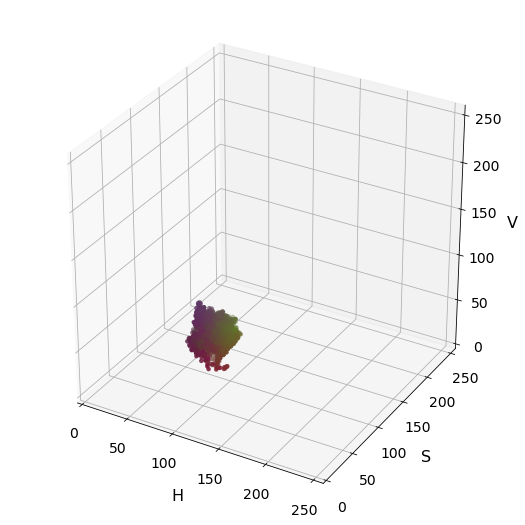

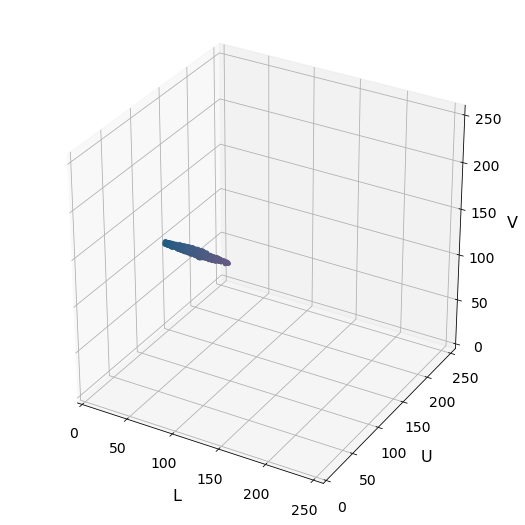

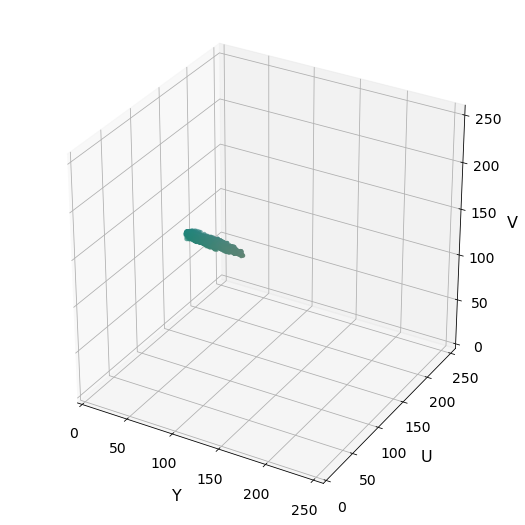

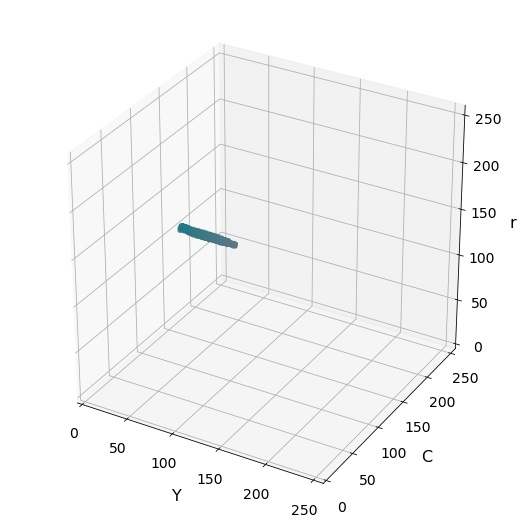

In [8]:
# Select a small fraction of pixels to plot by subsampling it
img = cv2.imread(cars[41])
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_HSV /255., axis_labels=list("HSV"))
plot3d(img_small_LUV, img_small_LUV /255., axis_labels=list("LUV"))
plot3d(img_small_YUV, img_small_YUV /255., axis_labels=list("YUV"))
plot3d(img_small_YCrCb, img_small_YCrCb /255., axis_labels=list("YCrCb"))
plt.show()

<h3>Color space visualization (Not-car image)</h3>

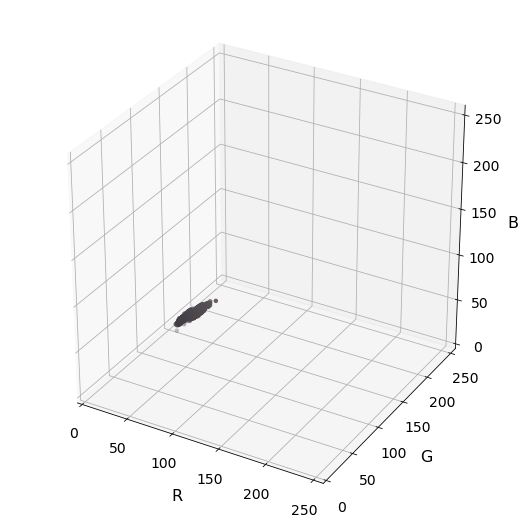

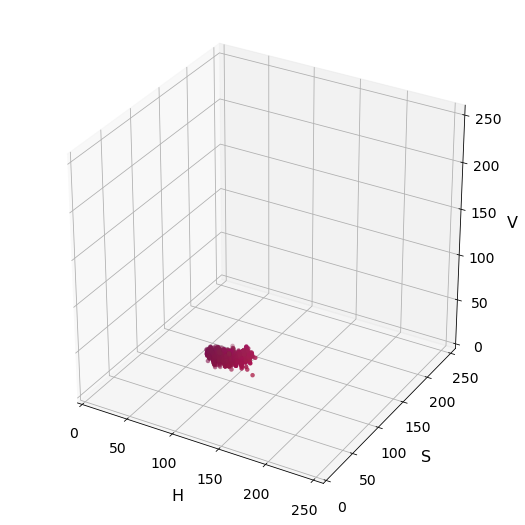

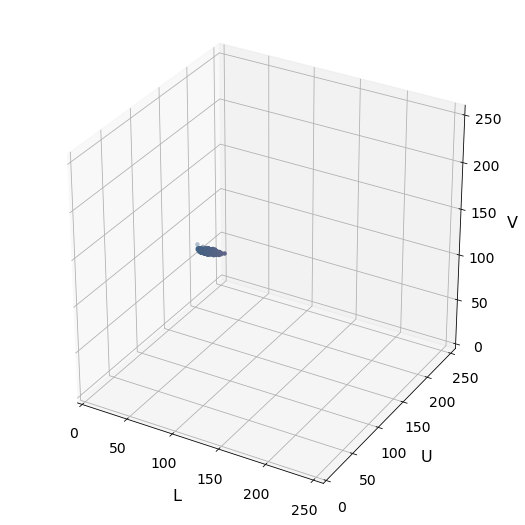

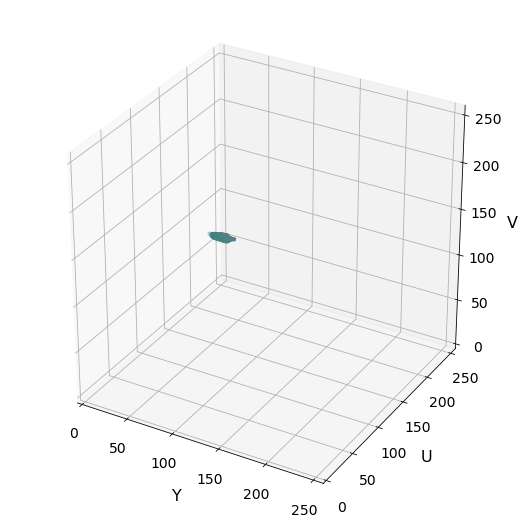

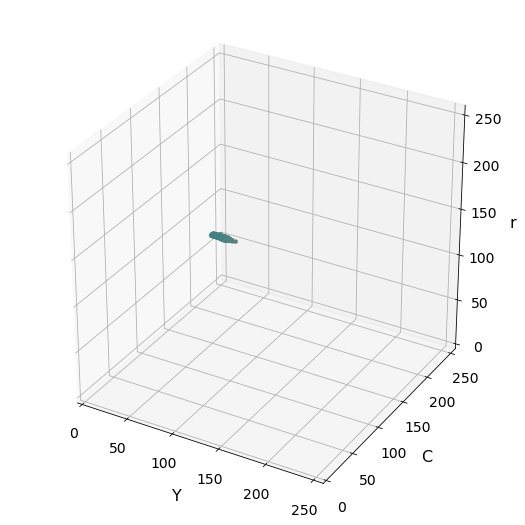

In [9]:
# Select a small fraction of pixels to plot by subsampling it
img = cv2.imread(notcars[41])
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_HSV /255., axis_labels=list("HSV"))
plot3d(img_small_LUV, img_small_LUV /255., axis_labels=list("LUV"))
plot3d(img_small_YUV, img_small_YUV /255., axis_labels=list("YUV"))
plot3d(img_small_YCrCb, img_small_YCrCb /255., axis_labels=list("YCrCb"))
plt.show()

<h2>Image Features Extraction Settings</h2>

In [10]:
#Final parameters after all tunings & trial and error
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

orient = 32  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

<h2>Pre-processing</h2>

In [11]:
# Extract features
car_features = extract_features(cars, 
                        color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars,  
                        color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print("vector length:", len(car_features))
print("vector length:", len(notcar_features))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                       
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Normalise input
#X = normalise(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

c:\users\arif makhdzir\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


vector length: 8792
vector length: 8968
Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 6576


<h2>Train Model</h2>

In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

10.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
0.01564 Seconds to predict 10 labels with SVC


<h2>Sliding Window Settings</h2>

<h3>Final Settings</h3>

In [33]:
#Final current
xy_windows = [(170, 170),(128, 128),(76, 76)]
overlaps = [0.50, 0.85, 0.75]
y_start_stops = [[500, 720],[400,720],[400,600]]
x_start_stops = [[600, 1280],[730, 1280],[730, 1280]]
colors = [(0,255,0), (255,0,0), (0,0,255), (0,128,128), (128,0,128)]

<h3>Sliding Window Visualization</h3>

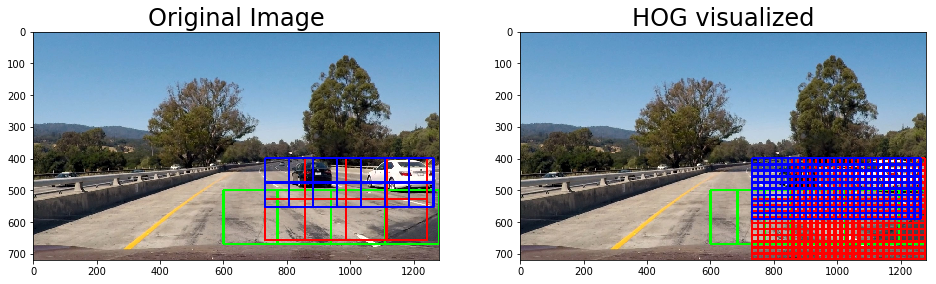

In [14]:
image = mpimg.imread('test_images/test1.jpg')
draw_image_no_overlap = np.copy(image)
draw_image_with_overlap = np.copy(image)
image = image.astype(np.float32)/255
    
for xy_window, overlap, color, y_start_stop, x_start_stop in zip(xy_windows, overlaps, colors, y_start_stops, x_start_stops):
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                               xy_window=xy_window, xy_overlap=(0, 0))
    draw_image_no_overlap = draw_boxes(draw_image_no_overlap, windows, color=color, thick=6) 
    
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                               xy_window=xy_window, xy_overlap=(overlap, overlap))

    draw_image_with_overlap = draw_boxes(draw_image_with_overlap, windows, color=color, thick=6)   

# Visualize car 41 image & hog
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
ax1.imshow(draw_image_no_overlap)
ax1.set_title('Original Image', fontsize=24)
ax2.imshow(draw_image_with_overlap)
ax2.set_title('HOG visualized', fontsize=24)
#f.savefig('output_images/sliding_window.png')


<h2>Heatmap visualization & final labeled image</h2>

c:\users\arif makhdzir\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
c:\users\arif makhdzir\appdata\local\programs\python\python35\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


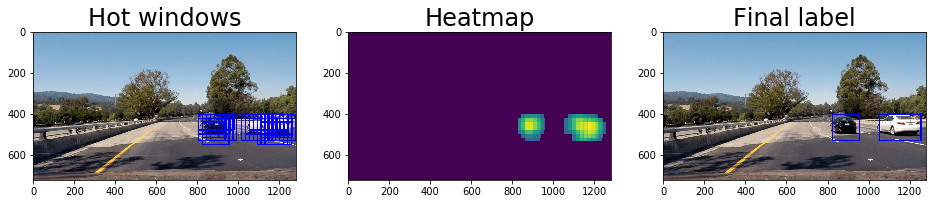

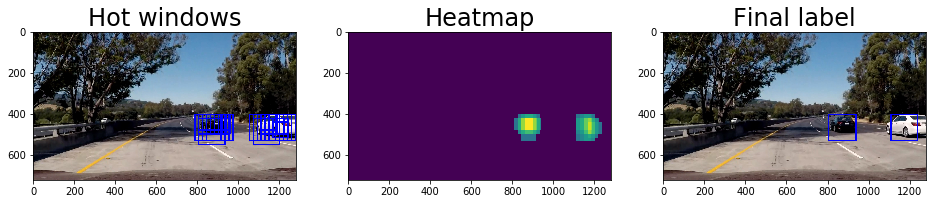

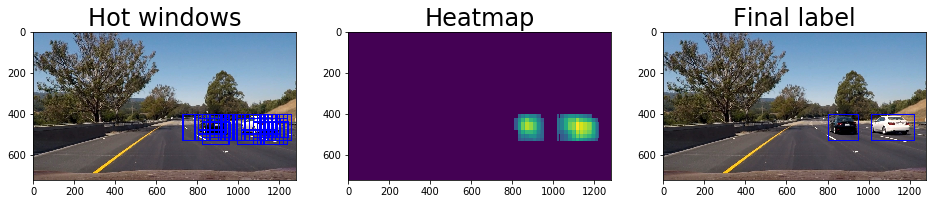

In [34]:
image1 = mpimg.imread('test_images/test4.jpg')
heatmap_visualization(image1)
image2 = mpimg.imread('test_images/test5.jpg')
heatmap_visualization(image2)
image3 = mpimg.imread('test_images/test6.jpg')
heatmap_visualization(image3)

<h2>Infer model</h2>

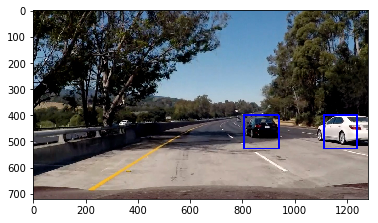

In [44]:
def image_pipeline(image):   
    ori_image = np.copy(image)
    image = image.astype(np.float32)/255
    hot_windows = []

    for xy_window, overlap, color, y_start_stop, x_start_stop in zip(xy_windows, overlaps, colors, y_start_stops, x_start_stops):
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                               xy_window=xy_window, xy_overlap=(overlap, overlap))

        temp_hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, hog_channel=hog_channel,
                                cell_per_block=cell_per_block, 
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)
        
        hot_windows = hot_windows + temp_hot_windows

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat, 4)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(ori_image, labels)
    
    return draw_img

image = mpimg.imread('test_images/test5.jpg')
img_pip = image_pipeline(image)
plt.imshow(img_pip)

<h2>Video Maker</h2>

In [45]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []

video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(image_pipeline) #NOTE: this function expects color images!!
video_output = "output_v8.mp4"
%time project_clip.write_videofile(video_output, audio=False)

print("Bounding boxes: ", bboxes_list)

[MoviePy] >>>> Building video output_v8.mp4
[MoviePy] Writing video output_v8.mp4



100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [49:34<00:02,  2.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_v8.mp4 

Wall time: 49min 35s
Bounding boxes:  []
